In [183]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

optimizer:
1. applicable to any algorithm
2. return updated amount weight

In [573]:
X = np.linspace(-5, 5, 100)
y = 0.1*X**3 + X**2 + 2 * X + 3 + np.random.randn(100) * 2 
y_linear = 2 * X + 3 + np.random.randn(100) * 2 
y_quadratic = X**2 + 2 * X + 3 + np.random.randn(100) * 2 
y_cubic = 0.1*X**3 + X**2 + 2 * X + 3 + np.random.randn(100) * 2 


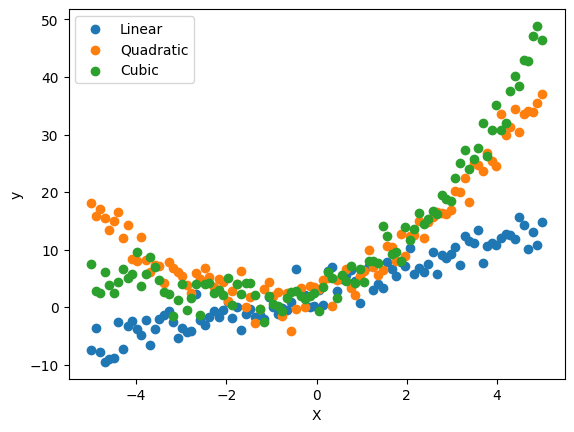

In [572]:
plt.scatter(X, y_linear, label='Linear')
plt.scatter(X, y_quadratic, label='Quadratic')
plt.scatter(X, y_cubic, label='Cubic')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

In [435]:
class LinearModel:
    def __init__(self, w=None, seed=15):
        np.random.seed(seed)
        if w is None:
            self.w = np.random.rand(2)
        else:
            self.w = w

    def update_weights(self, update_amount):
        assert update_amount.shape == self.w.shape, f"Error: shape mismatch (w={self.w.shape}, w2={update_amount.shape})"
        self.w += update_amount

    def get_weights(self):
        return self.w.copy()
    
    @staticmethod
    def variables(x):
        return np.array([x, 1])

    def predict(self, x):
        return self.w[0] * x + self.w[1]

    def derivative_mse(self, X, y_true, y_pred):
        grad_w1 = (-1/len(X)) * np.sum(X * (y_true - y_pred))
        grad_w2 = (-1/len(X)) * np.sum(y_true - y_pred)
        return np.array([grad_w1, grad_w2])
        
        

In [436]:
class QuadraticModel:
    def __init__(self, w=None, seed=15):
        np.random.seed(seed)
        if w is None:
            self.w = np.random.rand(2)
        else:
            self.w = w

    def update_weights(self, update_amount):
        assert update_amount.shape == self.w.shape, f"Error: shape mismatch (w={self.w.shape}, w2={update_amount.shape})"
        self.w += update_amount

    def get_weights(self):
        return self.w.copy()
    
    @staticmethod
    def variables(x):
        return np.array([x, 1])

    def predict(self, x):
        return self.w[0] * x**2 + self.w[1] * x

    def derivative_mse(self, X, y_true, y_pred):
        grad_w1 = (-1/len(X)) * np.sum(X**2 * (y_true - y_pred))
        grad_w2 = (-1/len(X)) * np.sum(X * (y_true - y_pred))
        return np.array([grad_w1, grad_w2])
        
        

In [354]:

def mse_loss(y_true, y_pred):
    return(np.mean((y_true-y_pred)**2))

In [629]:
class BatchGD:
    def __init__(self, model, lr=0.001, epsilon=10e-6, max_iter=50):
        self.model = model
        self.lr = lr
        self.epsilon = epsilon
        self.w_hist = []
        self.grad_hist = []
        self.mse_loss_hist = []
        self.optimized = False
        self.max_iter = max_iter

    def check_converge(self, w1, w2):
        assert len(w1) == len(w2), f"Error: Length mismatch (w1={len(w1)}, w2={len(w2)})"
        return all(abs(w1[i] - w2[i]) < self.epsilon for i in range(len(w1)))
        

    def optimize(self, X, y_true, verbose=False):
        iter_cnt = 0
        
        if verbose:
            print(f"iter: {iter_cnt}, weights = {self.model.get_weights()}")

        self.w_hist.append(self.model.get_weights())
        
        while(iter_cnt < self.max_iter):
            w1 = self.model.get_weights()
            # compute y_pred
            y_pred = self.model.predict(X)
            
            # compute mse
            mse = mse_loss(y_true, y_pred)
            
            # Compute gradients
            gradient = self.model.derivative_mse(X, y_true, y_pred)

            # Update parameters using learning rate
            self.model.update_weights(-1 * gradient * self.lr)
            
            w2 = self.model.get_weights()

            # record
            self.w_hist.append(self.model.get_weights())
            self.grad_hist.append(gradient)
            self.mse_loss_hist.append(mse)

            
            iter_cnt += 1
            if verbose:
                print(f"iter: {iter_cnt}, weights = {w2}, mse = {mse}")
            # early stopping
            if self.check_converge(w1, w2):
                break

        self.optimized = True

    def vis(self, color='red', fig=None, ax=None):
        if not self.optimized:
            raise f"This is not optimized yet!"

        if not fig and not ax:
            fig, ax = plt.subplots(figsize=(8, 6))
        alpha = 0.2
        alpha_interval = (1.0 - alpha)/len(self.w_hist)
        ax.scatter([], [], c=color, label="BGD")
        ax.scatter(self.w_hist[0][0], self.w_hist[0][1], c=color, alpha=alpha, s=6)
        for i in range(1, len(self.w_hist)):
            alpha += alpha_interval
            ax.scatter(self.w_hist[i][0], self.w_hist[i][1], c=color, alpha=alpha, s=6)
            ax.arrow(
                self.w_hist[i-1][0], 
                self.w_hist[i-1][1], 
                self.w_hist[i][0]-self.w_hist[i-1][0], 
                self.w_hist[i][1]- self.w_hist[i-1][1],
                ec=color,
                alpha=alpha
            )
        # ax.xlim((min(self.x_his)-1, max(self.x_his)+1))
        # ax.ylim((min(self.y_his)-1, max(self.y_his)+1))
        ax.legend()

In [630]:
class MiniBatchGD:
    def __init__(self, model, lr=0.001, epsilon=10e-6, max_iter=50):
        self.model = model
        self.lr = lr
        self.epsilon = epsilon
        self.w_hist = []
        self.grad_hist = []
        self.mse_loss_hist = []
        self.optimized = False
        self.max_iter = max_iter

    def check_converge(self, w1, w2):
        assert len(w1) == len(w2), f"Error: Length mismatch (w1={len(w1)}, w2={len(w2)})"
        return all(abs(w1[i] - w2[i]) < self.epsilon for i in range(len(w1)))
        

    def optimize(self, X, y_true, verbose=False):
        iter_cnt = 0
        
        if verbose:
            print(f"iter: {iter_cnt}, weights = {self.model.get_weights()}")

        self.w_hist.append(self.model.get_weights())
        
        while(iter_cnt < self.max_iter):
            w1 = self.model.get_weights()

            # randomly select one data point
            idx = np.random.choice(X.shape[0], size=32)
            X_selected = X[idx]
            y_selected = y_true[idx]
            
            # compute y_pred
            y_pred = self.model.predict(X_selected)
            
            # compute mse
            mse = mse_loss(y_selected, y_pred)

            
            # Compute gradients
            gradient = self.model.derivative_mse(X_selected, y_selected, y_pred)

            # Update parameters using learning rate
            self.model.update_weights(-1 * gradient * self.lr)
            
            w2 = self.model.get_weights()

            # record
            self.w_hist.append(self.model.get_weights())
            self.grad_hist.append(gradient)
            self.mse_loss_hist.append(mse)

            
            iter_cnt += 1
            if verbose:
                print(f"iter: {iter_cnt}, weights = {w2}, mse = {mse}")
            # early stopping
            if self.check_converge(w1, w2):
                break

        self.optimized = True

    def vis(self, color='red', fig=None, ax=None):
        if not self.optimized:
            raise f"This is not optimized yet!"

        if not fig and not ax:
            fig, ax = plt.subplots(figsize=(8, 6))
        alpha = 0.2
        alpha_interval = (1.0 - alpha)/len(self.w_hist)
        ax.scatter([], [], c=color, label="Mini_BGD")
        ax.scatter(self.w_hist[0][0], self.w_hist[0][1], c=color, alpha=alpha, s=6)
        for i in range(1, len(self.w_hist)):
            alpha += alpha_interval
            ax.scatter(self.w_hist[i][0], self.w_hist[i][1], c=color, alpha=alpha, s=6)
            ax.arrow(
                self.w_hist[i-1][0], 
                self.w_hist[i-1][1], 
                self.w_hist[i][0]-self.w_hist[i-1][0], 
                self.w_hist[i][1]- self.w_hist[i-1][1],
                ec=color,
                alpha=alpha
            )
        # ax.xlim((min(self.x_his)-1, max(self.x_his)+1))
        # ax.ylim((min(self.y_his)-1, max(self.y_his)+1))
        ax.legend()

In [631]:
class SGD:
    def __init__(self, model, lr=0.001, epsilon=10e-6, max_iter=50):
        self.model = model
        self.lr = lr
        self.epsilon = epsilon
        self.w_hist = []
        self.grad_hist = []
        self.mse_loss_hist = []
        self.optimized = False
        self.max_iter = max_iter

    def check_converge(self, w1, w2):
        assert len(w1) == len(w2), f"Error: Length mismatch (w1={len(w1)}, w2={len(w2)})"
        return all(abs(w1[i] - w2[i]) < self.epsilon for i in range(len(w1)))
        

    def optimize(self, X, y_true, verbose=False):
        iter_cnt = 0
        
        if verbose:
            print(f"iter: {iter_cnt}, weights = {self.model.get_weights()}")

        self.w_hist.append(self.model.get_weights())
        
        while(iter_cnt < self.max_iter):
            w1 = self.model.get_weights()

            # randomly select one data point
            idx = np.random.choice(X.shape[0], size=1)
            X_selected = X[idx]
            y_selected = y_true[idx]
            
            # compute y_pred
            y_pred = self.model.predict(X_selected)
            
            # compute mse
            mse = mse_loss(y_selected, y_pred)

            
            # Compute gradients
            gradient = self.model.derivative_mse(X_selected, y_selected, y_pred)

            # Update parameters using learning rate
            self.model.update_weights(-1 * gradient * self.lr)
            
            w2 = self.model.get_weights()

            # record
            self.w_hist.append(self.model.get_weights())
            self.grad_hist.append(gradient)
            self.mse_loss_hist.append(mse)

            
            iter_cnt += 1
            if verbose:
                print(f"iter: {iter_cnt}, weights = {w2}, mse = {mse}")
            # early stopping
            if self.check_converge(w1, w2):
                break

        self.optimized = True

    def vis(self, color='red', fig=None, ax=None):
        if not self.optimized:
            raise f"This is not optimized yet!"

        if not fig and not ax:
            fig, ax = plt.subplots(figsize=(8, 6))
        alpha = 0.2
        alpha_interval = (1.0 - alpha)/len(self.w_hist)
        ax.scatter([], [], c=color, label="SGD")
        ax.scatter(self.w_hist[0][0], self.w_hist[0][1], c=color, alpha=alpha, s=6)
        for i in range(1, len(self.w_hist)):
            alpha += alpha_interval
            ax.scatter(self.w_hist[i][0], self.w_hist[i][1], c=color, alpha=alpha, s=6)
            ax.arrow(
                self.w_hist[i-1][0], 
                self.w_hist[i-1][1], 
                self.w_hist[i][0]-self.w_hist[i-1][0], 
                self.w_hist[i][1]- self.w_hist[i-1][1],
                ec=color,
                alpha=alpha
            )
        # ax.xlim((min(self.x_his)-1, max(self.x_his)+1))
        # ax.ylim((min(self.y_his)-1, max(self.y_his)+1))
        ax.legend()

In [636]:
class GDMomentum:
    def __init__(self, model, lr=0.001, gamma=0.9, epsilon=10e-6, max_iter=50):
        self.model = model
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.w_hist = []
        self.grad_hist = []
        self.mse_loss_hist = []
        self.update_amount_hist = []
        self.optimized = False
        self.max_iter = max_iter

    def check_converge(self, w1, w2):
        assert len(w1) == len(w2), f"Error: Length mismatch (w1={len(w1)}, w2={len(w2)})"
        return all(abs(w1[i] - w2[i]) < self.epsilon for i in range(len(w1)))
        

    def optimize(self, X, y_true, verbose=False):
        iter_cnt = 0
        
        if verbose:
            print(f"iter: {iter_cnt}, weights = {self.model.get_weights()}")

        self.w_hist.append(self.model.get_weights())
        
        while(iter_cnt < self.max_iter):
            w1 = self.model.get_weights()

            # randomly select one data point
            idx = np.random.choice(X.shape[0], size=32)
            X_selected = X[idx]
            y_selected = y_true[idx]
            
            # compute y_pred
            y_pred = self.model.predict(X_selected)
            
            # compute mse
            mse = mse_loss(y_selected, y_pred)

            
            # Compute gradients
            gradient = self.model.derivative_mse(X_selected, y_selected, y_pred)

            # Update parameters using learning rate
            update_amount =  gradient * self.lr
            if self.update_amount_hist:
                update_amount += self.gamma * self.update_amount_hist[-1]
            self.model.update_weights(-1 * update_amount)
            
            w2 = self.model.get_weights()

            # record
            self.w_hist.append(self.model.get_weights())
            self.grad_hist.append(gradient)
            self.mse_loss_hist.append(mse)
            self.update_amount_hist.append(update_amount)

            
            iter_cnt += 1
            if verbose:
                print(f"iter: {iter_cnt}, weights = {w2}, mse = {mse}")
            # early stopping
            if self.check_converge(w1, w2):
                break

        self.optimized = True

    def vis(self, color='red', fig=None, ax=None):
        if not self.optimized:
            raise f"This is not optimized yet!"

        if not fig and not ax:
            fig, ax = plt.subplots(figsize=(8, 6))
        alpha = 0.2
        alpha_interval = (1.0 - alpha)/len(self.w_hist)
        ax.scatter([], [], c=color, label="Nesterov")
        ax.scatter(self.w_hist[0][0], self.w_hist[0][1], c=color, alpha=alpha, s=6)
        for i in range(1, len(self.w_hist)):
            alpha += alpha_interval
            ax.scatter(self.w_hist[i][0], self.w_hist[i][1], c=color, alpha=alpha, s=6)
            ax.arrow(
                self.w_hist[i-1][0], 
                self.w_hist[i-1][1], 
                self.w_hist[i][0]-self.w_hist[i-1][0], 
                self.w_hist[i][1]- self.w_hist[i-1][1],
                ec=color,
                alpha=alpha
            )
        # ax.xlim((min(self.x_his)-1, max(self.x_his)+1))
        # ax.ylim((min(self.y_his)-1, max(self.y_his)+1))
        ax.legend()

In [637]:
class NAG:
    def __init__(self, model, lr=0.001, gamma=0.9, epsilon=10e-6, max_iter=50):
        # Nesterov accelerated gradient
        self.model = model
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.w_hist = []
        self.grad_hist = []
        self.mse_loss_hist = []
        self.update_amount_hist = []
        self.optimized = False
        self.max_iter = max_iter

    def check_converge(self, w1, w2):
        assert len(w1) == len(w2), f"Error: Length mismatch (w1={len(w1)}, w2={len(w2)})"
        return all(abs(w1[i] - w2[i]) < self.epsilon for i in range(len(w1)))
        

    def optimize(self, X, y_true, verbose=False):
        iter_cnt = 0
        
        if verbose:
            print(f"iter: {iter_cnt}, weights = {self.model.get_weights()}")

        self.w_hist.append(self.model.get_weights())
        
        while(iter_cnt < self.max_iter):
            w1 = self.model.get_weights()

            # randomly select one data point
            idx = np.random.choice(X.shape[0], size=32)
            X_selected = X[idx]
            y_selected = y_true[idx]
            
            # compute y_pred
            y_pred = self.model.predict(X_selected)
            
            # compute mse
            mse = mse_loss(y_selected, y_pred)

            # previous_momentum
            previous_momentum = np.zeros_like(self.w_hist[-1])
            if self.update_amount_hist:
                previous_momentum = self.update_amount_hist[-1]

            # calculate potential next position
            potential_update_amount = previous_momentum * self.lr

            # update weights
            self.model.update_weights(-1 * potential_update_amount)
            
            # Compute look_ahead_gradient gradients
            look_ahead_gradient = self.model.derivative_mse(X_selected, y_selected, y_pred)

            # restore weights
            self.model.update_weights(potential_update_amount)

            # final update_amount
            final_update_amount =  self.gamma * previous_momentum + self.lr * look_ahead_gradient

            self.model.update_weights(-1 * final_update_amount)
        
            w2 = self.model.get_weights()

            # record
            self.w_hist.append(self.model.get_weights())
            self.grad_hist.append(look_ahead_gradient)
            self.mse_loss_hist.append(mse)
            self.update_amount_hist.append(final_update_amount)

            
            iter_cnt += 1
            if verbose:
                print(f"iter: {iter_cnt}, weights = {w2}, mse = {mse}")
            # early stopping
            if self.check_converge(w1, w2):
                break

        self.optimized = True

    def vis(self, color='red', fig=None, ax=None):
        if not self.optimized:
            raise f"This is not optimized yet!"

        if not fig and not ax:
            fig, ax = plt.subplots(figsize=(8, 6))
        alpha = 0.2
        alpha_interval = (1.0 - alpha)/len(self.w_hist)
        ax.scatter([], [], c=color, label="NAG")
        ax.scatter(self.w_hist[0][0], self.w_hist[0][1], c=color, alpha=alpha, s=6)
        for i in range(1, len(self.w_hist)):
            alpha += alpha_interval
            ax.scatter(self.w_hist[i][0], self.w_hist[i][1], c=color, alpha=alpha, s=6)
            ax.arrow(
                self.w_hist[i-1][0], 
                self.w_hist[i-1][1], 
                self.w_hist[i][0]-self.w_hist[i-1][0], 
                self.w_hist[i][1]- self.w_hist[i-1][1],
                ec=color,
                alpha=alpha
            )
        # ax.xlim((min(self.x_his)-1, max(self.x_his)+1))
        # ax.ylim((min(self.y_his)-1, max(self.y_his)+1))
        ax.legend()

In [663]:
class Adagrad:
    def __init__(self, model, lr=0.01, gamma=0.9, epsilon=10e-6, max_iter=50, epsilon_adagrad=10e-8):
        # larger update on infrequent and smaller update for frequent parameters
        self.model = model
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.w_hist = []
        self.grad_hist = []
        self.mse_loss_hist = []
        self.update_amount_hist = []
        self.optimized = False
        self.max_iter = max_iter
        self.epsilon_adagrad = epsilon_adagrad
        self.grad_squared_hist = []

    def check_converge(self, w1, w2):
        assert len(w1) == len(w2), f"Error: Length mismatch (w1={len(w1)}, w2={len(w2)})"
        return all(abs(w1[i] - w2[i]) < self.epsilon for i in range(len(w1)))
        

    def optimize(self, X, y_true, verbose=False):
        iter_cnt = 0
        
        if verbose:
            print(f"iter: {iter_cnt}, weights = {self.model.get_weights()}")

        self.w_hist.append(self.model.get_weights())
        
        while(iter_cnt < self.max_iter):
            w1 = self.model.get_weights()

            # randomly select one data point
            idx = np.random.choice(X.shape[0], size=32)
            X_selected = X[idx]
            y_selected = y_true[idx]
            
            # compute y_pred
            y_pred = self.model.predict(X_selected)
            
            # compute mse
            mse = mse_loss(y_selected, y_pred)

            # Compute gradients
            gradient = self.model.derivative_mse(X_selected, y_selected, y_pred)
            gradient_squared = gradient * gradient
            
            if not self.grad_squared_hist:
                lr_modifier = (gradient * gradient + self.epsilon_adagrad)**0.5
            else:
                lr_modifier = (self.grad_squared_hist[-1] + gradient_squared + self.epsilon_adagrad)**0.5
            lr_coef = self.lr / lr_modifier
            

            # Update parameters using learning rate
            self.model.update_weights(-1 * gradient * lr_coef)
            
        
            w2 = self.model.get_weights()

            # record
            self.w_hist.append(self.model.get_weights())
            self.grad_hist.append(gradient)
            self.mse_loss_hist.append(mse)
            self.grad_squared_hist.append(gradient_squared)

            
            iter_cnt += 1
            if verbose:
                print(f"iter: {iter_cnt}, weights = {w2}, mse = {mse}")
            # early stopping
            if self.check_converge(w1, w2):
                break

        self.optimized = True

    def vis(self, color='red', fig=None, ax=None):
        if not self.optimized:
            raise f"This is not optimized yet!"

        if not fig and not ax:
            fig, ax = plt.subplots(figsize=(8, 6))
        alpha = 0.2
        alpha_interval = (1.0 - alpha)/len(self.w_hist)
        ax.scatter([], [], c=color, label="Adagrad")
        ax.scatter(self.w_hist[0][0], self.w_hist[0][1], c=color, alpha=alpha, s=6)
        for i in range(1, len(self.w_hist)):
            alpha += alpha_interval
            ax.scatter(self.w_hist[i][0], self.w_hist[i][1], c=color, alpha=alpha, s=6)
            ax.arrow(
                self.w_hist[i-1][0], 
                self.w_hist[i-1][1], 
                self.w_hist[i][0]-self.w_hist[i-1][0], 
                self.w_hist[i][1]- self.w_hist[i-1][1],
                ec=color,
                alpha=alpha
            )
        # ax.xlim((min(self.x_his)-1, max(self.x_his)+1))
        # ax.ylim((min(self.y_his)-1, max(self.y_his)+1))
        ax.legend()

In [711]:
class Adadelta:
    def __init__(self, model, rho=0.9, epsilon=10e-6, max_iter=50, epsilon_ada=10e-8):
        # larger update on infrequent and smaller update for frequent parameters
        self.model = model
        self.rho = rho
        self.epsilon = epsilon
        self.w_hist = []
        self.grad_hist = []
        self.mse_loss_hist = []
        self.running_avg_update = np.zeros_like(model.get_weights())
        self.optimized = False
        self.max_iter = max_iter
        self.epsilon_ada = epsilon_ada
        self.running_avg_grad = np.zeros_like(model.get_weights())

    def check_converge(self, w1, w2):
        assert len(w1) == len(w2), f"Error: Length mismatch (w1={len(w1)}, w2={len(w2)})"
        return all(abs(w1[i] - w2[i]) < self.epsilon for i in range(len(w1)))
        

    def optimize(self, X, y_true, verbose=False):
        iter_cnt = 0
        
        if verbose:
            print(f"iter: {iter_cnt}, weights = {self.model.get_weights()}")

        self.w_hist.append(self.model.get_weights())
        
        while(iter_cnt < self.max_iter):
            w1 = self.model.get_weights()

            # randomly select one data point
            idx = np.random.choice(X.shape[0], size=32)
            X_selected = X[idx]
            y_selected = y_true[idx]
            
            # compute y_pred
            y_pred = self.model.predict(X_selected)
            
            # compute mse
            mse = mse_loss(y_selected, y_pred)

            # Compute gradients
            gradient = self.model.derivative_mse(X_selected, y_selected, y_pred)
            gradient_squared = gradient * gradient


            # update running_avg_grad
            self.running_avg_grad = self.rho * self.running_avg_grad + (1-self.rho) * gradient_squared
            
            # update amount
            update_amount = -(np.sqrt(self.running_avg_update + self.epsilon_ada) / np.sqrt(self.running_avg_grad + self.epsilon_ada)) * gradient
            

            # Update model weights
            self.model.update_weights(update_amount)

            # update running_avg_update
            self.running_avg_update = self.rho * self.running_avg_update + (1-self.rho) * (update_amount**2)
            
        
            w2 = self.model.get_weights()

            # record
            self.w_hist.append(self.model.get_weights())
            self.grad_hist.append(gradient)
            self.mse_loss_hist.append(mse)

            
            iter_cnt += 1
            if verbose:
                print(f"iter: {iter_cnt}, weights = {w2}, mse = {mse}")
            # early stopping
            if self.check_converge(w1, w2):
                break

        self.optimized = True

    def vis(self, color='red', fig=None, ax=None):
        if not self.optimized:
            raise f"This is not optimized yet!"

        if not fig and not ax:
            fig, ax = plt.subplots(figsize=(8, 6))
        alpha = 0.2
        alpha_interval = (1.0 - alpha)/len(self.w_hist)
        ax.scatter([], [], c=color, label="Adadelta")
        ax.scatter(self.w_hist[0][0], self.w_hist[0][1], c=color, alpha=alpha, s=6)
        for i in range(1, len(self.w_hist)):
            alpha += alpha_interval
            ax.scatter(self.w_hist[i][0], self.w_hist[i][1], c=color, alpha=alpha, s=6)
            ax.arrow(
                self.w_hist[i-1][0], 
                self.w_hist[i-1][1], 
                self.w_hist[i][0]-self.w_hist[i-1][0], 
                self.w_hist[i][1]- self.w_hist[i-1][1],
                ec=color,
                alpha=alpha
            )
        # ax.xlim((min(self.x_his)-1, max(self.x_his)+1))
        # ax.ylim((min(self.y_his)-1, max(self.y_his)+1))
        ax.legend()

In [712]:
class RMSprop:
    def __init__(self, model, lr=0.01, gamma=0.9, epsilon=10e-6, max_iter=50, epsilon_adagrad=10e-8):
        # larger update on infrequent and smaller update for frequent parameters
        self.model = model
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.w_hist = []
        self.grad_hist = []
        self.mse_loss_hist = []
        self.update_amount_hist = []
        self.optimized = False
        self.max_iter = max_iter
        self.epsilon_adagrad = epsilon_adagrad
        self.grad_squared_hist = []

    def check_converge(self, w1, w2):
        assert len(w1) == len(w2), f"Error: Length mismatch (w1={len(w1)}, w2={len(w2)})"
        return all(abs(w1[i] - w2[i]) < self.epsilon for i in range(len(w1)))
        

    def optimize(self, X, y_true, verbose=False):
        iter_cnt = 0
        
        if verbose:
            print(f"iter: {iter_cnt}, weights = {self.model.get_weights()}")

        self.w_hist.append(self.model.get_weights())
        
        while(iter_cnt < self.max_iter):
            w1 = self.model.get_weights()

            # randomly select one data point
            idx = np.random.choice(X.shape[0], size=32)
            X_selected = X[idx]
            y_selected = y_true[idx]
            
            # compute y_pred
            y_pred = self.model.predict(X_selected)
            
            # compute mse
            mse = mse_loss(y_selected, y_pred)

            # Compute gradients
            gradient = self.model.derivative_mse(X_selected, y_selected, y_pred)
            gradient_squared = gradient * gradient
            
            if not self.grad_squared_hist:
                lr_modifier = (gradient * gradient + self.epsilon_adagrad)**0.5
            else:
                lr_modifier = (self.gamma * self.grad_squared_hist[-1] + (1-self.gamma)* gradient_squared + self.epsilon_adagrad)**0.5
            lr_coef = self.lr / lr_modifier
            

            # Update parameters using learning rate
            self.model.update_weights(-1 * gradient * lr_coef)
            
        
            w2 = self.model.get_weights()

            # record
            self.w_hist.append(self.model.get_weights())
            self.grad_hist.append(gradient)
            self.mse_loss_hist.append(mse)
            self.grad_squared_hist.append(gradient_squared)

            
            iter_cnt += 1
            if verbose:
                print(f"iter: {iter_cnt}, weights = {w2}, mse = {mse}")
            # early stopping
            if self.check_converge(w1, w2):
                break

        self.optimized = True

    def vis(self, color='red', fig=None, ax=None):
        if not self.optimized:
            raise f"This is not optimized yet!"

        if not fig and not ax:
            fig, ax = plt.subplots(figsize=(8, 6))
        alpha = 0.2
        alpha_interval = (1.0 - alpha)/len(self.w_hist)
        ax.scatter([], [], c=color, label="RMSprop")
        ax.scatter(self.w_hist[0][0], self.w_hist[0][1], c=color, alpha=alpha, s=6)
        for i in range(1, len(self.w_hist)):
            alpha += alpha_interval
            ax.scatter(self.w_hist[i][0], self.w_hist[i][1], c=color, alpha=alpha, s=6)
            ax.arrow(
                self.w_hist[i-1][0], 
                self.w_hist[i-1][1], 
                self.w_hist[i][0]-self.w_hist[i-1][0], 
                self.w_hist[i][1]- self.w_hist[i-1][1],
                ec=color,
                alpha=alpha
            )
        # ax.xlim((min(self.x_his)-1, max(self.x_his)+1))
        # ax.ylim((min(self.y_his)-1, max(self.y_his)+1))
        ax.legend()

In [729]:
def vis_gt(X, y_true):
    def f(w, x, y_true):
        y_pred = w[0] * x + w[1]
        return mse_loss(y_true, y_pred)
    w1 = np.linspace(0.7, 1.4, 100)
    w2 = np.linspace(0, 1.4, 100)
    W1, W2 = np.meshgrid(w1, w2)
    
    mse_values = np.zeros_like(W1)  # Initialize storage (100, 100)

    for i in range(W1.shape[0]):  # Iterate over rows
        for j in range(W1.shape[1]):  # Iterate over columns
            w = np.array([W1[i, j], W2[i, j]])  # Get current (w1, w2) pair
            mse_values[i, j] = f(w, X, y_true)  # Compute loss for this weight pair
    
    fig, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(W1, W2, mse_values, levels=50, alpha=0.2)
    colorbar = fig.colorbar(contour)
    
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    colorbar.set_label('Loss')
    
    return(fig, ax)

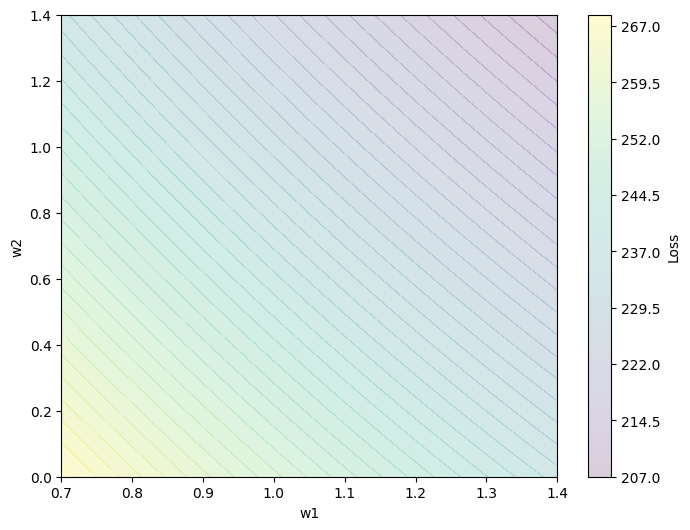

In [730]:
fig, ax = vis_gt(X, y)

In [731]:
def vis_quad_gt(X, y_true):
    def f(w, x, y_true):
        y_pred = w[0] * x**2 + w[1] * x
        return mse_loss(y_true, y_pred)
    w1 = np.linspace(0.7, 1.8, 100)
    w2 = np.linspace(0, 1.8, 100)
    W1, W2 = np.meshgrid(w1, w2)
    
    mse_values = np.zeros_like(W1)  # Initialize storage (100, 100)

    for i in range(W1.shape[0]):  # Iterate over rows
        for j in range(W1.shape[1]):  # Iterate over columns
            w = np.array([W1[i, j], W2[i, j]])  # Get current (w1, w2) pair
            mse_values[i, j] = f(w, X, y_true)  # Compute loss for this weight pair
    
    fig, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(W1, W2, mse_values, levels=50, alpha=0.2)
    colorbar = fig.colorbar(contour)
    
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    colorbar.set_label('Loss')
    return(fig, ax)

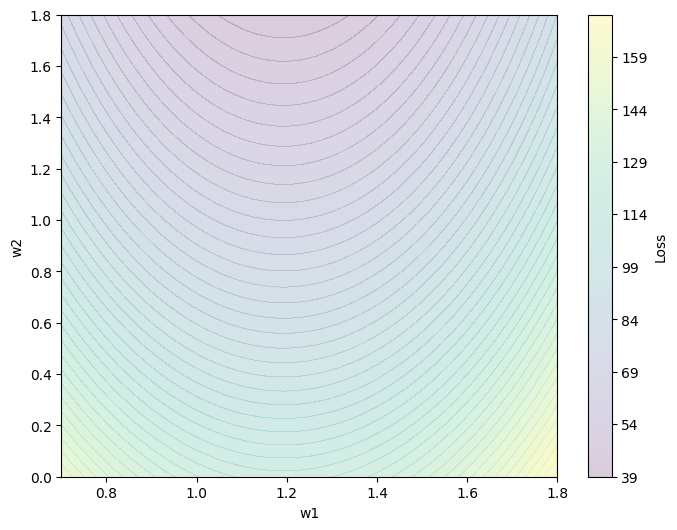

In [732]:
fig, ax = vis_quad_gt(X, y)

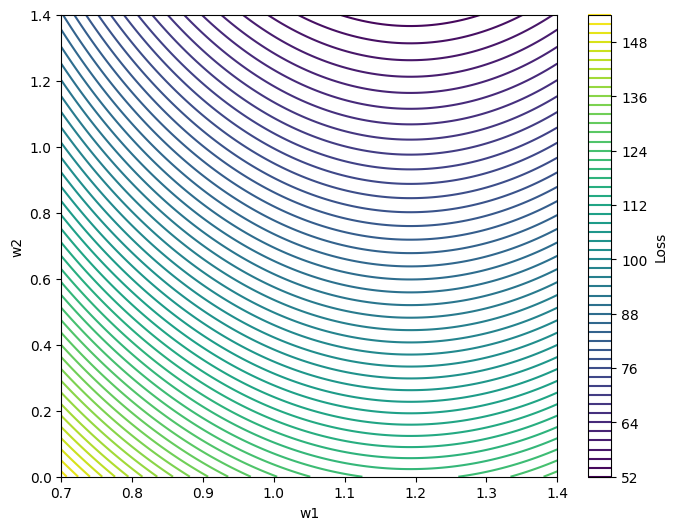

In [597]:
m_bgd = QuadraticModel()
m_sgd = QuadraticModel()
m_minibdg = QuadraticModel()
bgd = BatchGD(m_bgd)
sgd = SGD(m_sgd)
minigd = MiniBatchGD(m_minibdg)
fig, ax = vis_quad_gt(X, y)

In [566]:
bgd.optimize(X, y, verbose=True)
sgd.optimize(X, y, verbose=True)
minigd.optimize(X, y, verbose=True)

iter: 0, weights = [0.8488177  0.17889592]
iter: 1, weights = [0.89685203 0.20651446], mse = 117.26729297304676
iter: 2, weights = [0.93863786 0.23389819], mse = 111.43375949618347
iter: 3, weights = [0.97498801 0.26104911], mse = 106.67542078374072
iter: 4, weights = [1.00660958 0.2879692 ], mse = 102.73656028969727
iter: 5, weights = [1.03411769 0.31466043], mse = 99.42356505857306
iter: 6, weights = [1.05804743 0.34112474], mse = 96.58982091599024
iter: 7, weights = [1.07886429 0.36736405], mse = 94.12428182228088
iter: 8, weights = [1.0969732  0.39338029], mse = 91.94281966249645
iter: 9, weights = [1.11272643 0.41917534], mse = 89.98167814200005
iter: 10, weights = [1.12643042 0.4447511 ], mse = 88.19251897188774
iter: 11, weights = [1.13835173 0.47010941], mse = 86.5386730258416
iter: 12, weights = [1.14872227 0.49525214], mse = 84.99230336383725
iter: 13, weights = [1.15774377 0.52018111], mse = 83.53225831476757
iter: 14, weights = [1.16559171 0.54489815], mse = 82.142446764031

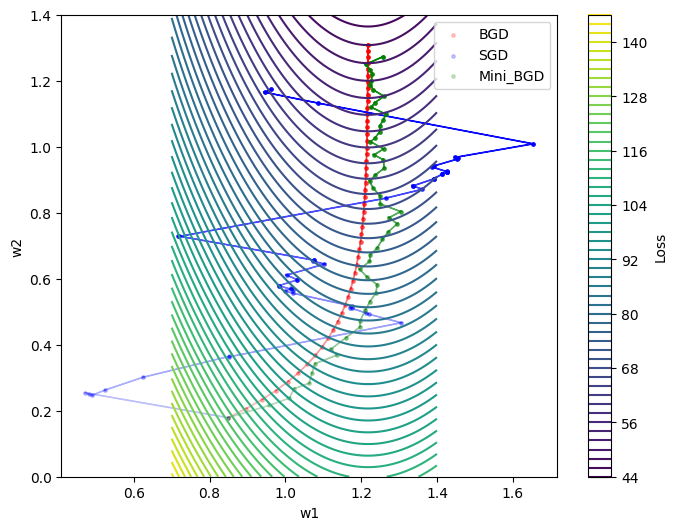

In [567]:
bgd.vis(fig=fig, ax=ax)
sgd.vis(fig=fig, ax=ax, color='blue')
minigd.vis(fig=fig, ax=ax, color='green')
display(fig) 

In [634]:
def batch_experiment(X, y, predict_model, vis_func):
    # model
    m_bgd = predict_model()
    m_sgd = predict_model()
    m_minibdg = predict_model()

    # optimizer
    bgd = BatchGD(m_bgd)
    sgd = SGD(m_sgd)
    minigd = MiniBatchGD(m_minibdg)

    # get contour
    fig, ax = vis_func(X, y)

    # optimize
    bgd.optimize(X, y, verbose=False)
    sgd.optimize(X, y, verbose=False)
    minigd.optimize(X, y, verbose=False)

    # plot
    bgd.vis(fig=fig, ax=ax)
    sgd.vis(fig=fig, ax=ax, color='blue')
    minigd.vis(fig=fig, ax=ax, color='green')
    
    # display(fig) 

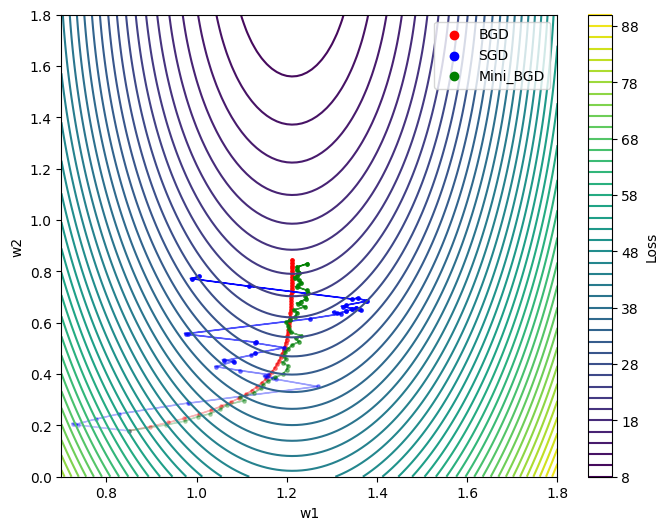

In [635]:
batch_experiment(X, y_quadratic, QuadraticModel, vis_quad_gt)

In [733]:
def experiment(X, y, predict_model, vis_func):
    # model
    m_minibdg = predict_model()
    m_sgd_momentum = predict_model()
    m_nag = predict_model()
    m_adagrad = predict_model()
    m_rmsprop = predict_model()
    m_adadelta = predict_model()

    # optimizer
    minigd = MiniBatchGD(m_minibdg)
    sgdm = SGDMomentum(m_sgd_momentum, gamma=0.7)
    nag = NAG(m_nag, gamma=0.7)
    adagrad = Adagrad(m_adagrad)
    rmsprop = RMSprop(m_rmsprop)
    adadelta = Adadelta(m_adadelta, rho=0.7)

    # get contour
    fig, ax = vis_func(X, y)

    # optimize
    minigd.optimize(X, y, verbose=False)
    sgdm.optimize(X, y, verbose=False)
    nag.optimize(X, y, verbose=False)
    adagrad.optimize(X, y, verbose=False)
    rmsprop.optimize(X, y, verbose=False)
    adadelta.optimize(X, y, verbose=False)

    # plot
    minigd.vis(fig=fig, ax=ax, color='green')
    sgdm.vis(fig=fig, ax=ax, color='brown')
    nag.vis(fig=fig, ax=ax, color='magenta')
    adagrad.vis(fig=fig, ax=ax, color='red')
    rmsprop.vis(fig=fig, ax=ax, color='blue')
    adadelta.vis(fig=fig, ax=ax, color='black')
    
    # display(fig) 

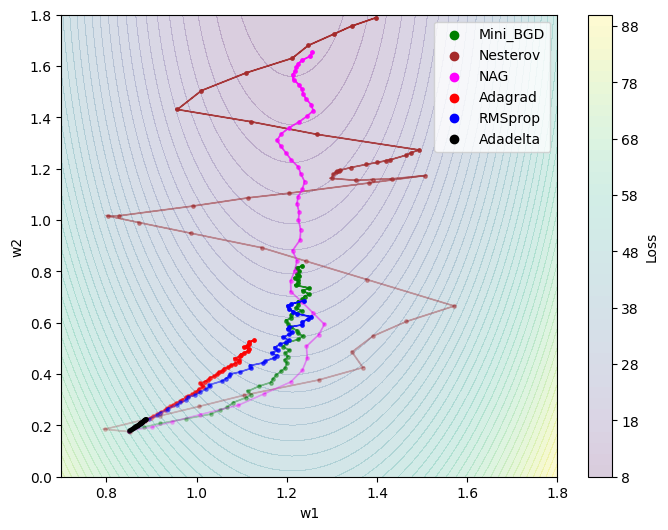

In [734]:
experiment(X, y_quadratic, QuadraticModel, vis_quad_gt)

iter: 0, weights = [0.8488177  0.17889592]
iter: 1, weights = [0.8588177  0.18889592], mse = 119.42384563587527
iter: 2, weights = [0.8688177  0.19889592], mse = 146.3157069410034
iter: 3, weights = [0.8788177  0.20889592], mse = 140.19087447100196
iter: 4, weights = [0.8888177  0.21889592], mse = 99.66404670795127
iter: 5, weights = [0.8988177  0.22889592], mse = 99.17235480147387
iter: 6, weights = [0.9088177  0.23889592], mse = 57.15200144109089
iter: 7, weights = [0.9188177  0.24889592], mse = 87.1722957250033
iter: 8, weights = [0.9088177  0.25889592], mse = 54.88817767235648
iter: 9, weights = [0.9188177  0.26889592], mse = 110.02180696281556
iter: 10, weights = [0.9088177  0.27889592], mse = 106.88055713579698
iter: 11, weights = [0.9188177  0.28889592], mse = 130.63505081250133
iter: 12, weights = [0.9288177  0.29889592], mse = 107.98158322052171
iter: 13, weights = [0.9388177  0.30889592], mse = 124.93215315098291
iter: 14, weights = [0.9488177  0.31889592], mse = 90.162585254

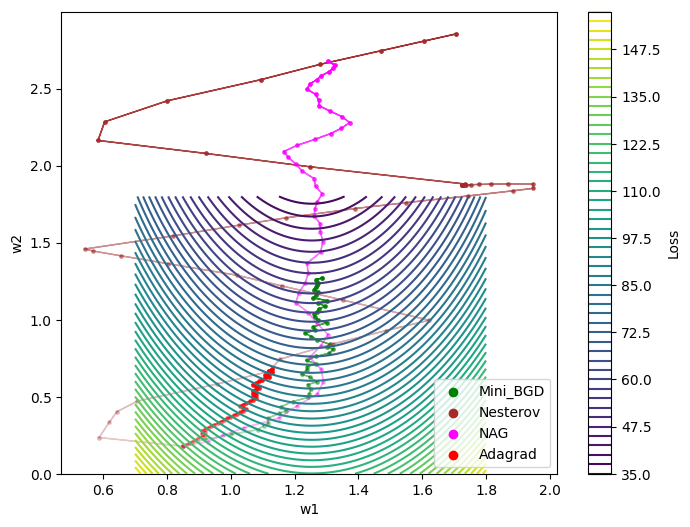

In [651]:
experiment(X, y_cubic, QuadraticModel, vis_quad_gt)

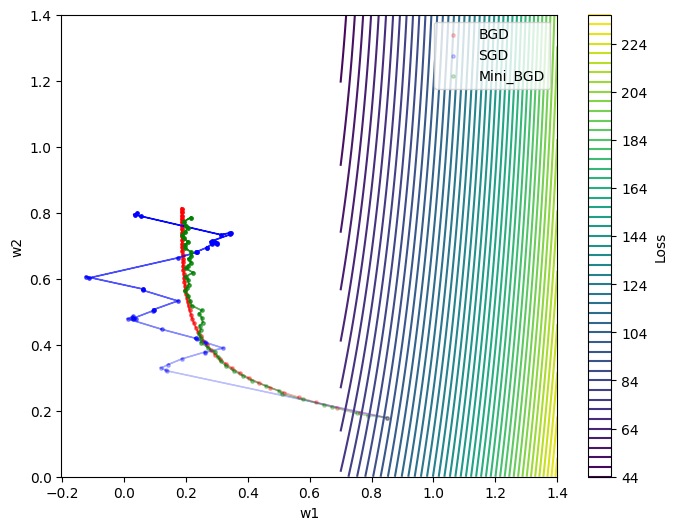

In [585]:
experiment(X, y_linear, QuadraticModel, vis_quad_gt)

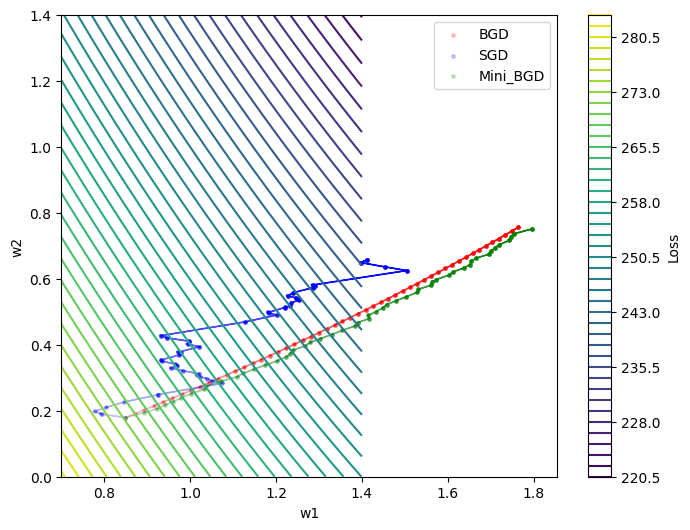

In [590]:
experiment(X, y_cubic, LinearModel, vis_gt)

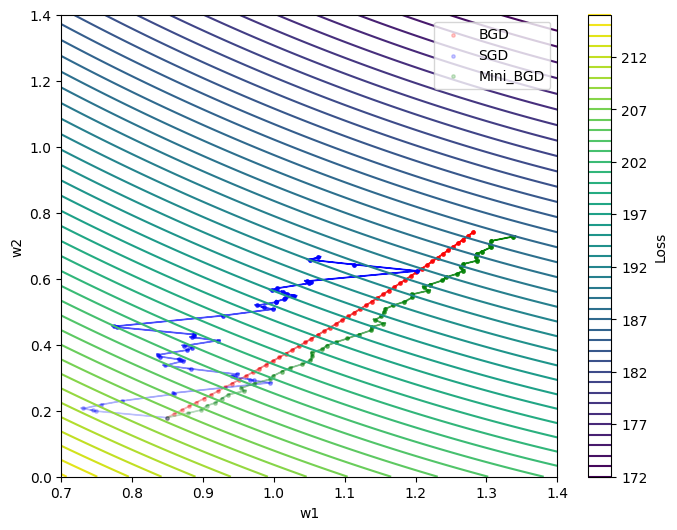

In [591]:
experiment(X, y_quadratic, LinearModel, vis_gt)

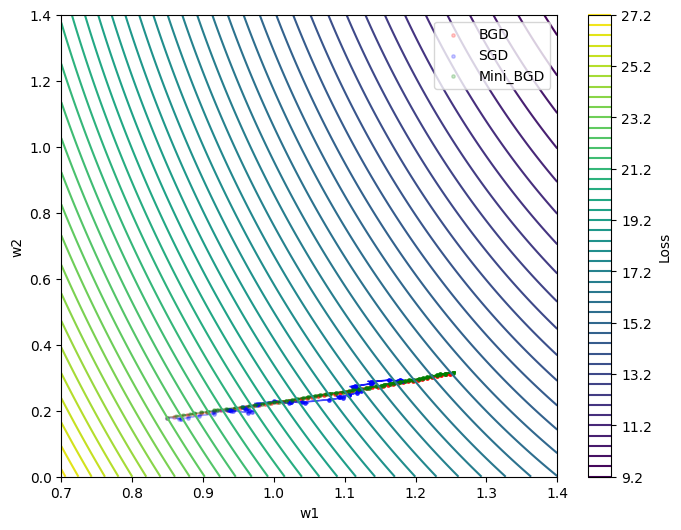

In [592]:
experiment(X, y_linear, LinearModel, vis_gt)